In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import math
import itertools
from prettytable import PrettyTable
from matplotlib.colors import ListedColormap

In [2]:
def read_maf(maf_file_name):
    maf_fields = ["Hugo_Symbol", "Tumor_Sample_Barcode"]
    maf = pd.read_csv(maf_file_name, sep='\t', usecols=maf_fields, comment='#')
    return maf

def get_benchmark_genes_original():
    benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
    benchmark_df = pd.read_csv(benchmark_file_name, sep='\t', usecols=["gene", "general_driver"])
    # getting only genes in some benchmark, excluding only gene in possible false positives:
    benchmark_df = benchmark_df[benchmark_df["general_driver"] >= 0]
    benchmark_driver_genes = list(benchmark_df["gene"])
    return benchmark_driver_genes

def get_benchmark_genes():
    benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
    benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
    benchmark_df = benchmark_df.set_index("gene")

    driver_benchmark = set(benchmark_df[benchmark_df["ncg"] > 0].index) | set(benchmark_df[benchmark_df["cgc"] > 0].index) | set(benchmark_df[benchmark_df["intogen"] > 0].index) | set(benchmark_df[benchmark_df["bailey"] > 0].index)
    false_positive_benchmark = set(benchmark_df[benchmark_df["ncg_possible_false_positive"] > 0].index)
    driver_benchmark = driver_benchmark - false_positive_benchmark
    return list(driver_benchmark)

'''
Input: a CaGeDINN file name with result
Output: a list with priorited genes
'''
def get_gene_list(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep='\t', usecols=["gene"])
    genes_result = list(results_df["gene"])
    
    return genes_result[:N]

def get_genes_by_frequency(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene", "mutated_samples"])
    results_df = results_df.sort_values(by=["mutated_samples"], ascending=False)
    return list(results_df["gene"])[:N]

def get_genes_by_weighted_frequency(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene"])
    return list(results_df["gene"])[:N]

def get_genes_by_neighbors_score(results_file_name, N):
    results_df = pd.read_csv(results_file_name, comment='#', sep='\t', usecols=["gene", "score_from_neighbors"])
    results_df = results_df.sort_values(by=["score_from_neighbors"], ascending=False)
    return list(results_df["gene"])[:N]
    

# Results of nCOP
def get_gene_list_nCOP(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = ' ', usecols=[0], names=["gene"])
    return list(results_df["gene"])[:N]

# Results of MutSigCV
def get_gene_list_mutsigcv(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=["gene"])
    return list(results_df["gene"])[:N]

# Results of MUFFINN
def get_gene_list_muffinn(results_file_name, N):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=["Gene_Symbol"])
    return list(results_df["Gene_Symbol"])[:N]


'''
Output: precision
'''
def get_precision(genes_result, benchmark_driver_genes):
    into_driver_benchmark = 0
    precision_list = []

    i = 0
    for gene in genes_result:
        if gene in benchmark_driver_genes:
            into_driver_benchmark = into_driver_benchmark + 1
        i = i + 1
        precision_list.append(into_driver_benchmark / i)

    return precision_list

def get_dcg(gene_results, benchmark_values):
    dcg_list = []
    dcg = 0
    
    pos = 1
    for gene in gene_results:
        gene_value = benchmark_values[gene]
    
        dcg = dcg + (gene_value / math.log(pos + 1, 2))

        dcg_list.append(dcg)
        pos = pos + 1
    return dcg_list

def get_heatmap_df(cancer_type, gene_results, benchmark_df):
    d = {}
    for gene in gene_results:
        benchmark_in = [0, 0, 0, 0, 0, 0]
        if gene in benchmark_df.index:
            if benchmark_df.loc[gene]["ncg"] > 0:
                benchmark_in[0] = 1
            if benchmark_df.loc[gene]["cgc"] > 0:
                benchmark_in[1] = 2
            if benchmark_df.loc[gene]["intogen"] > 0:
                benchmark_in[2] = 3
            if benchmark_df.loc[gene]["bailey"] > 0:
                benchmark_in[3] = 4
            specific_driver_column = "intogen_" + cancer_type
            if benchmark_df.loc[gene][specific_driver_column] > 0:
                benchmark_in[4] = 5
            if benchmark_df.loc[gene]["ncg_possible_false_positive"] > 0:
                benchmark_in[5] = 6
        d[gene] = benchmark_in
        
    df = pd.DataFrame(data=d, index=["NCG", "CGC", "intOGen", "Bailey 2018", "Specific", "NCG Possible False Positive"])
    return df

In [3]:
def generate_graphs_precision(all_results, benchmark_driver_genes, N):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        main_plot = True
        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]
            
            precision_list = get_precision(gene_results, benchmark_driver_genes)
            if N > len(precision_list):
                N_aux = len(precision_list)
                top_N_list = [x for x in range(1, N_aux+1)]
            else:
                top_N_list = [x for x in range(1, N+1)] 
            
            if main_plot:
                ax.plot(top_N_list, precision_list, '-', lw=4.0, label=result_name, zorder=100)
                main_plot = False
            else:
                ax.plot(top_N_list, precision_list, '-', lw=2.0, label=result_name)
        if position == 1:
            ax.legend()
        ax.set_title(cancer_type)
        if position >= 4:
            ax.set_xlabel("Prioritized genes")
        if position == 1 or position == 4:
            ax.set_ylabel("Precision")
        ax.set_ylim(0.0, 1.1)
        position = position + 1
        plt.grid(True)
    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    plt.show()
    return fig

def generate_boxplot_precision(all_results, benchmark_driver_genes, N):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        data = []
        methods = []
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        main_plot = True
        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]
            precision_list = get_precision(gene_results, benchmark_driver_genes)
            data.append(precision_list)
            methods.append(result_name)

        ax.set_title(cancer_type)
        ax.boxplot(data, labels=methods, showfliers=False)

        if position >= 4:
            ax.set_xlabel("Methods")
        if position == 1 or position == 4:
            ax.set_ylabel("Precision")
        ax.set_ylim(0.0, 1.1)
        position = position + 1

    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    plt.show()
    return fig
    
def generate_graphs_dcg(all_results, N):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
        specific_driver_column = "specific_driver_" + cancer_type
        benchmark_df = pd.read_csv(benchmark_file_name, sep='\t', usecols=["gene", specific_driver_column])
        
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        main_plot = True
        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]
            
            benchmark_df_gene_results = benchmark_df[benchmark_df["gene"].isin(gene_results)]
            
            genes_in_benchmark = list(benchmark_df_gene_results["gene"])
            genes_not_in_benchmark = [[gene, 0] for gene in gene_results if gene not in genes_in_benchmark]
            
            benchmark_df_gene_results = benchmark_df_gene_results.append(pd.DataFrame(genes_not_in_benchmark, columns=["gene", specific_driver_column]), ignore_index=True)

            benchmark_values = benchmark_df_gene_results.set_index("gene")[specific_driver_column].to_dict()
            
            dcg_list = get_dcg(gene_results, benchmark_values)
            if N > len(dcg_list):
                N_aux = len(dcg_list)
                top_N_list = [x for x in range(1, N_aux+1)]
            else:
                top_N_list = [x for x in range(1, N+1)]
            
            if main_plot:
                ax.plot(top_N_list, dcg_list, '-', lw=4.0, label=result_name, zorder=100)
                main_plot = False
            else:
                ax.plot(top_N_list, dcg_list, '-', lw=2.0, label=result_name)

        if position == 1:
            ax.legend()
        ax.set_title(cancer_type)
        if position >= 4:
            ax.set_xlabel("Prioritized genes")
        if position == 1 or position == 4:
            ax.set_ylabel("DCG")
        position = position + 1
        plt.grid(True)
    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    plt.show()
    return fig

def generate_boxplot_dcg(all_results, N):
    number_of_columns = 3
    number_of_rows = math.ceil(len(all_results)/number_of_columns)
    fig = plt.figure(figsize=(5*number_of_columns, 4*number_of_rows))
    position = 1
    for cancer_type in all_results:
        benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
        specific_driver_column = "specific_driver_" + cancer_type
        benchmark_df = pd.read_csv(benchmark_file_name, sep='\t', usecols=["gene", specific_driver_column])

        data = []
        methods = []
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        main_plot = True
        for result_name in all_results[cancer_type]:
            gene_results = all_results[cancer_type][result_name]

            benchmark_df_gene_results = benchmark_df[benchmark_df["gene"].isin(gene_results)]

            genes_in_benchmark = list(benchmark_df_gene_results["gene"])
            genes_not_in_benchmark = [[gene, 0] for gene in gene_results if gene not in genes_in_benchmark]

            benchmark_df_gene_results = benchmark_df_gene_results.append(pd.DataFrame(genes_not_in_benchmark, columns=["gene", specific_driver_column]), ignore_index=True)

            benchmark_values = benchmark_df_gene_results.set_index("gene")[specific_driver_column].to_dict()

            dcg_list = get_dcg(gene_results, benchmark_values)

            data.append(dcg_list)
            methods.append(result_name)

        ax.set_title(cancer_type)
        ax.boxplot(data, labels=methods, showfliers=False)

        if position >= 4:
            ax.set_xlabel("Methods")
        if position == 1 or position == 4:
            ax.set_ylabel("DCG")
        position = position + 1

    fig.tight_layout(h_pad=1.5, w_pad=1.0)
    plt.show()
    return fig

def generate_benchmarks_heatmap(all_results, N, benchmark_df):
    ncols = 1
    nrows = len(all_results)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12 * ncols, 2 * nrows))
    colors = ["white", "green", "orange", "blue", "purple", "mustard", "red"]
    
    plot_row = 0
    for cancer_type in all_results:
        gene_results = all_results[cancer_type]

        df = get_heatmap_df(cancer_type, gene_results, benchmark_df)
        hm = sns.heatmap(ax=ax[plot_row], vmin=0, vmax=7, data=df, linewidths=2.0, linecolor="beige", cmap=sns.xkcd_palette(colors), cbar=False)
        hm.xaxis.tick_top()
        hm.set_xticklabels(gene_results, rotation=90)
        hm.set_ylabel(cancer_type, fontsize=16)
        plot_row = plot_row + 1
    
    fig.tight_layout(h_pad=1.0, w_pad=1)
    plt.show()
    return fig

# Precision

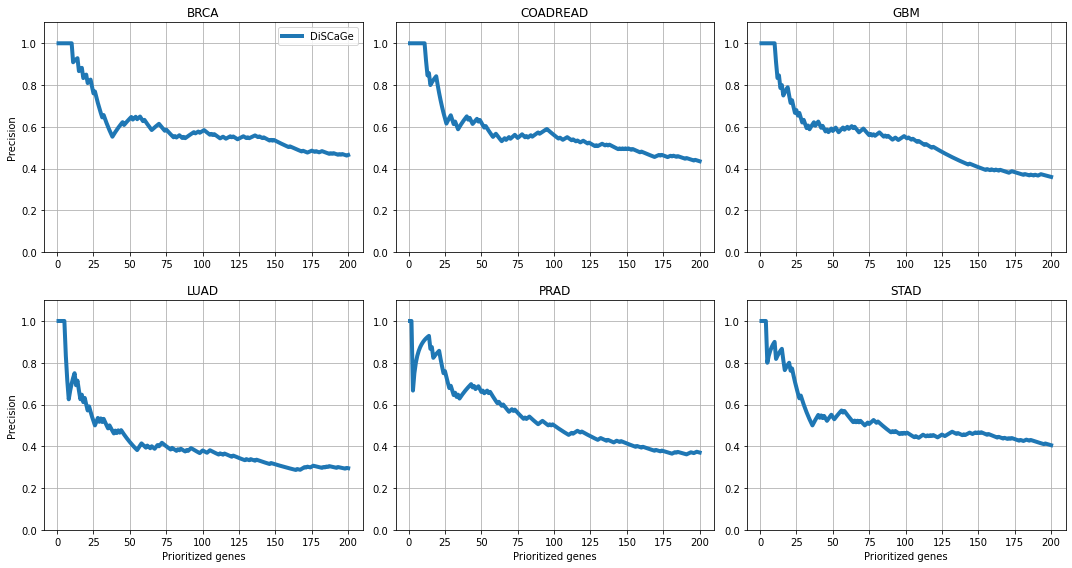

In [4]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list
    
    all_results[cancer_type] = all_results_cancer_type


fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)

output_file_name = "precision.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Discounted Cumulative Gain (DCG)

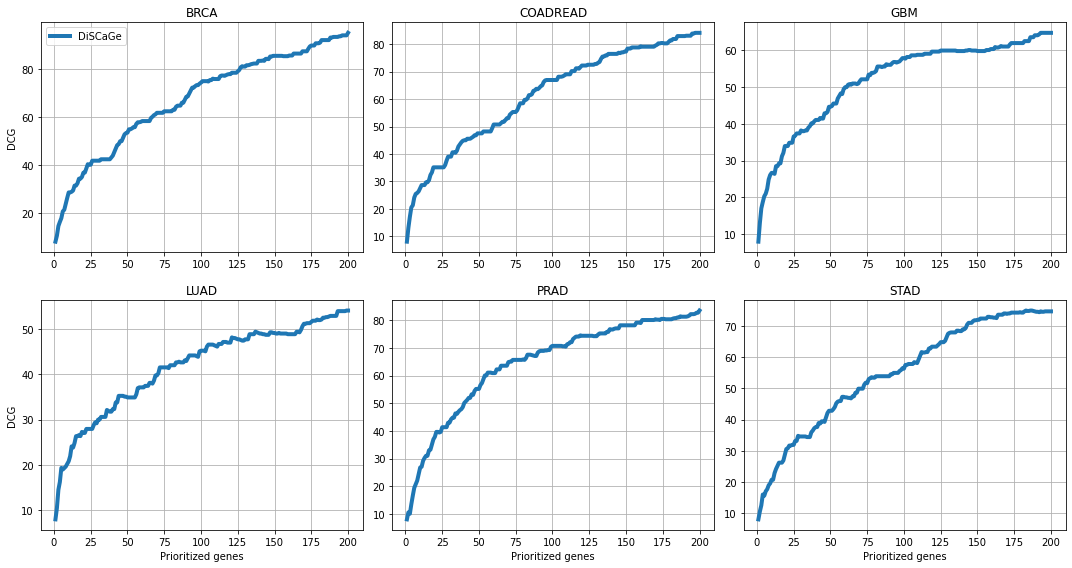

In [5]:
N = 200
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list

    all_results[cancer_type] = all_results_cancer_type
    
fig = generate_graphs_dcg(all_results, N)

output_file_name = "dcg.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Comparison with frequency

PRECISION:


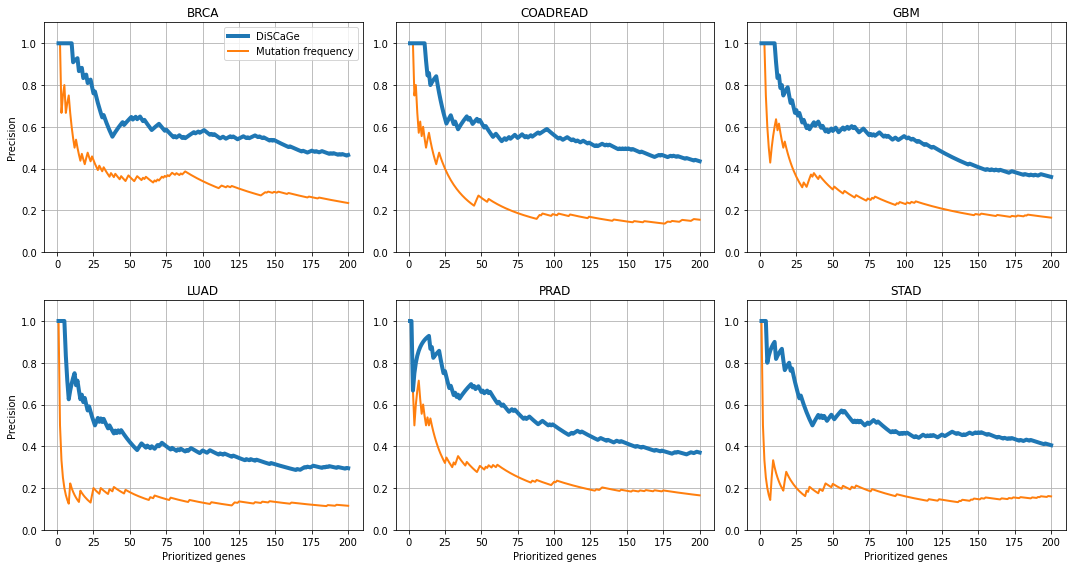


DCG:


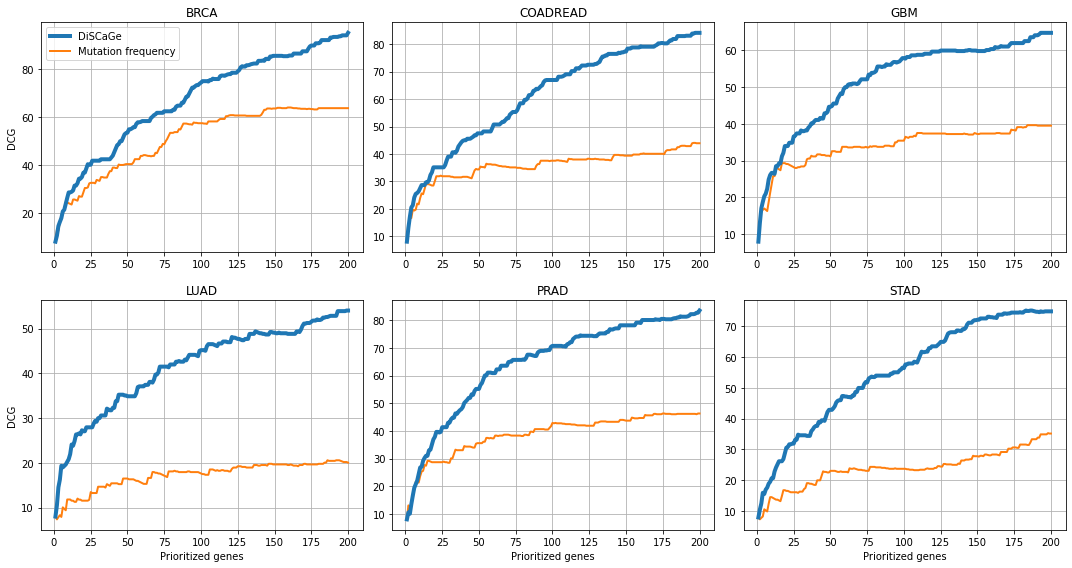

In [6]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.gene.report"
    result_gene_list = get_genes_by_frequency(result_file_name, N)
    all_results_cancer_type["Mutation frequency"] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)
output_file_name = "precision_frequency.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')


print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)
output_file_name = "dcg_frequency.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Comparison with weighted frequency

PRECISION:


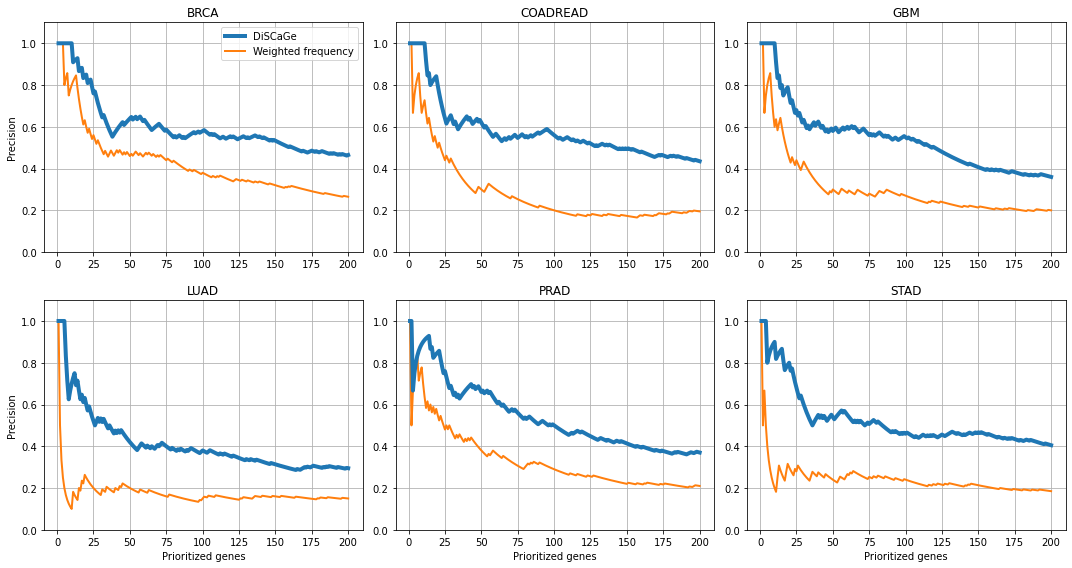


DCG:


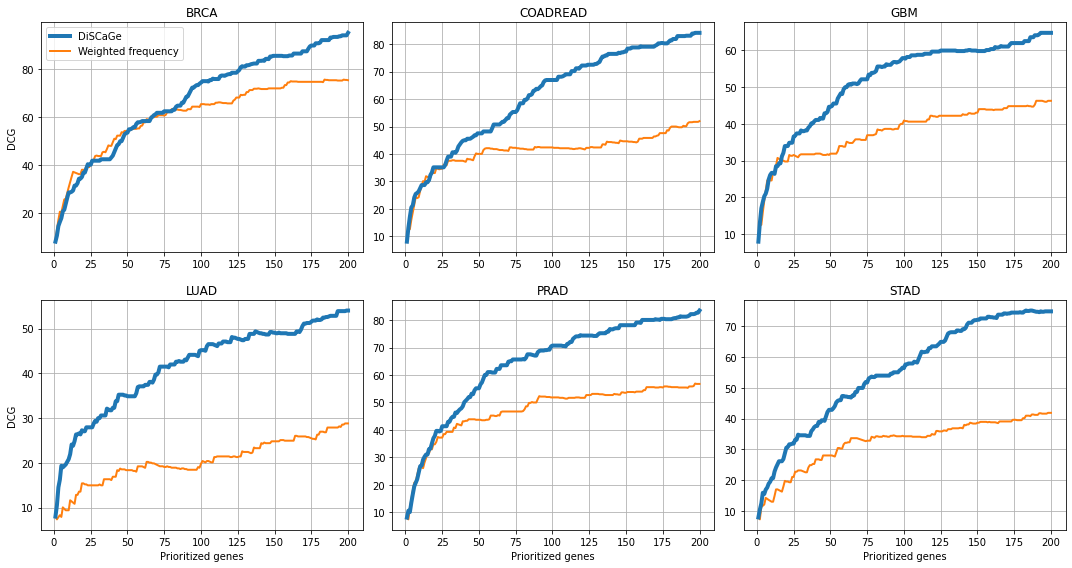

In [7]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list

    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.mutation.score"
    result_gene_list = get_genes_by_weighted_frequency(result_file_name, N)
    all_results_cancer_type["Weighted frequency"] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type


print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)
output_file_name = "precision_weighted_frequency.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')


print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)
output_file_name = "dcg_weighted_frequency.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Comparison with scores from neighbors

PRECISION:


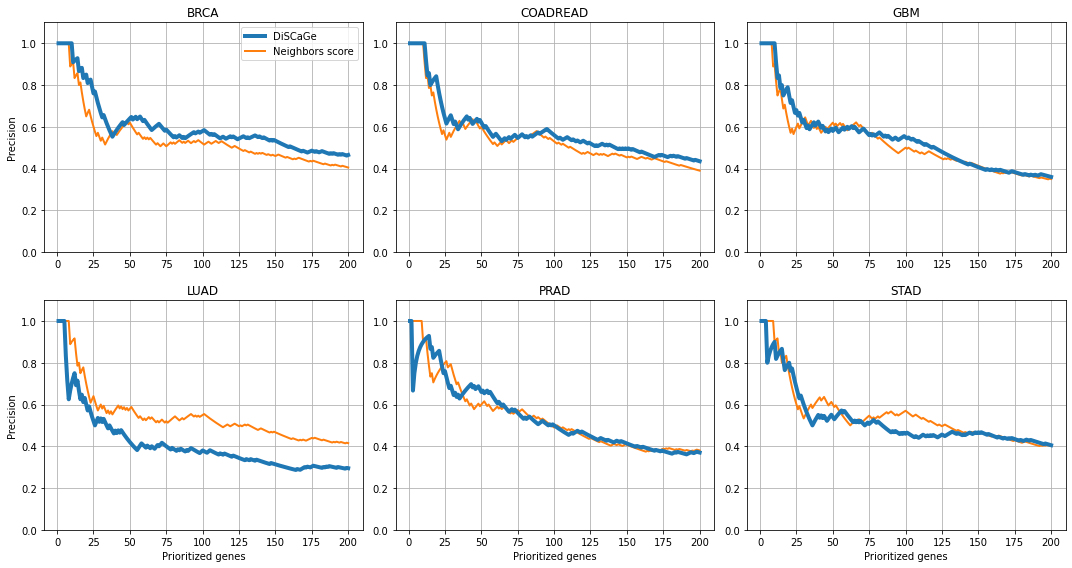


DCG:


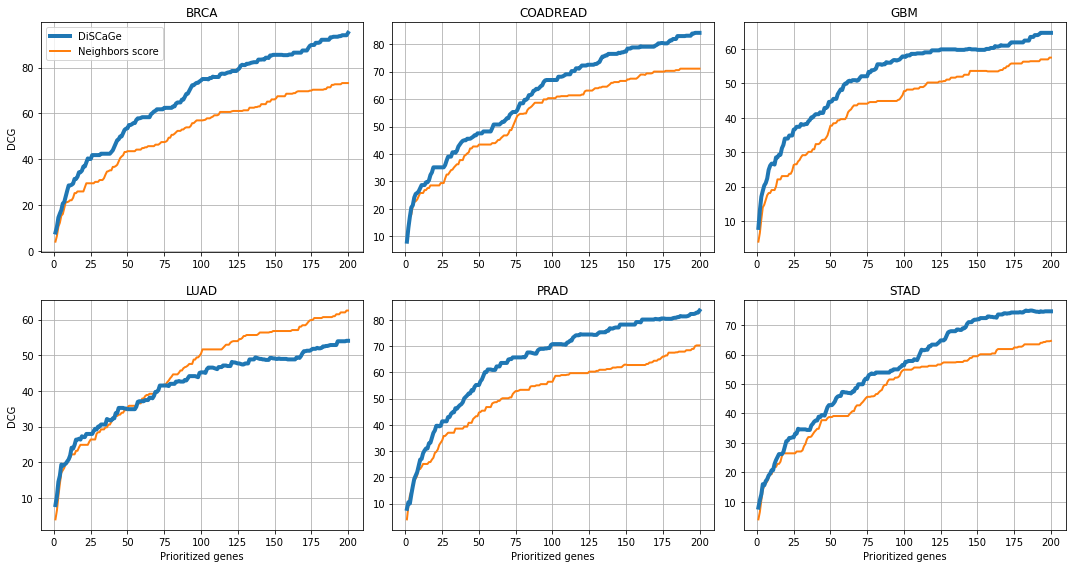

In [8]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list

    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_genes_by_neighbors_score(result_file_name, N)
    all_results_cancer_type["Neighbors score"] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)
output_file_name = "precision_neighbors_influence.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)
output_file_name = "dcg_neighbors_influence.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Comparion with related methods

PRECISION:


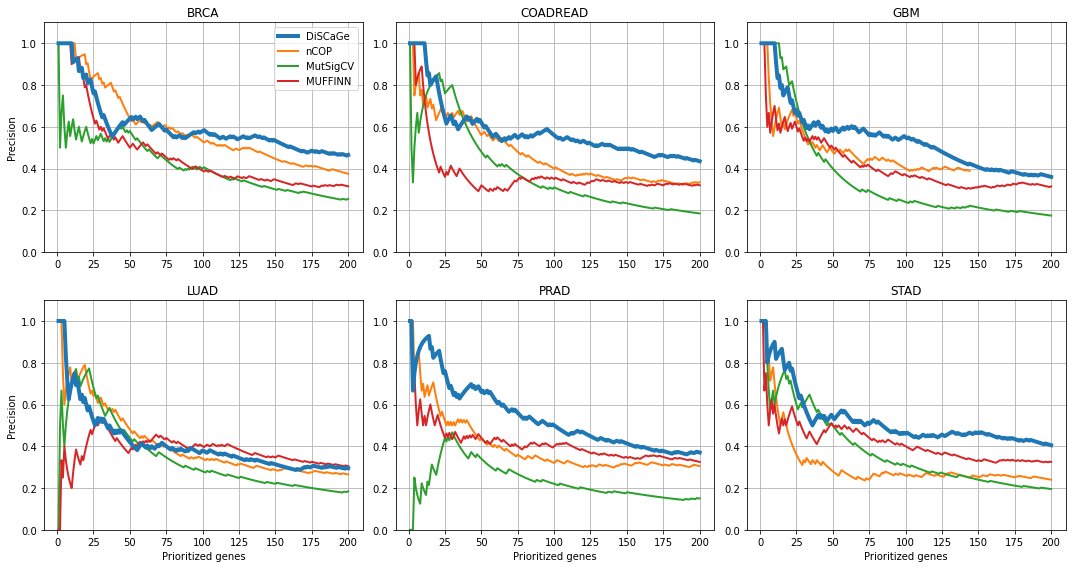

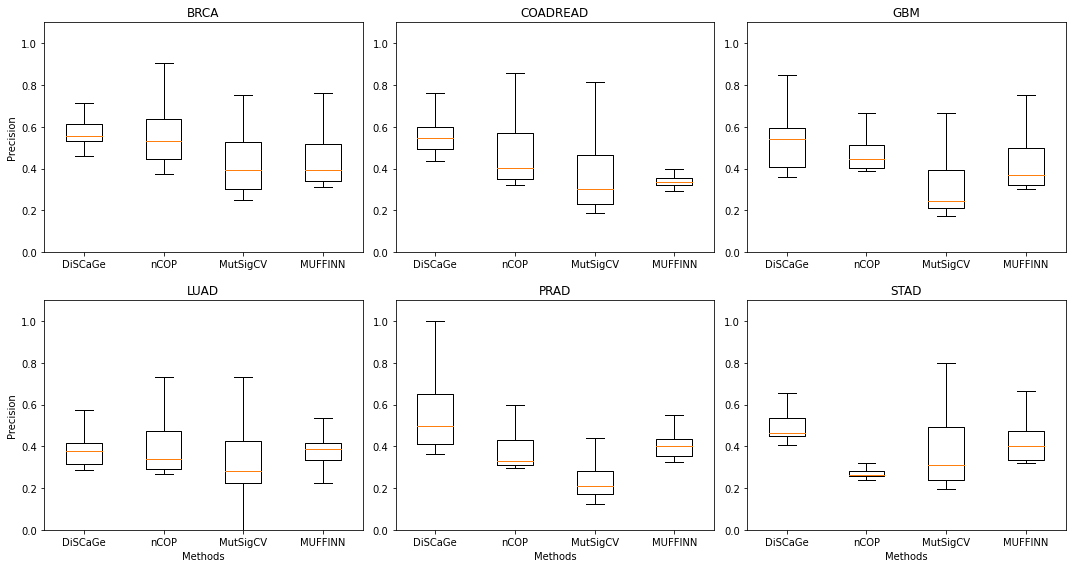


DCG:


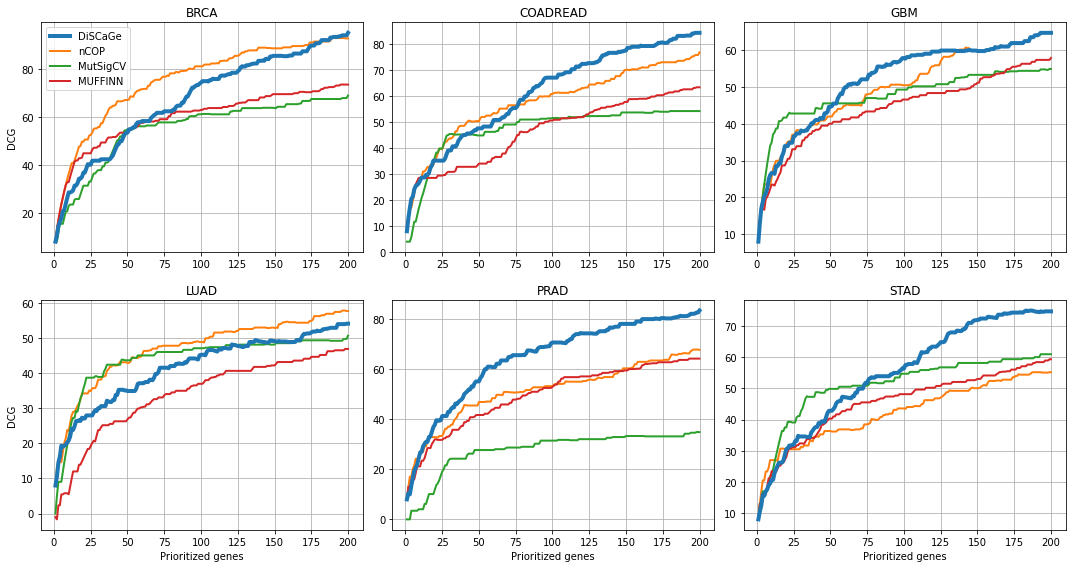

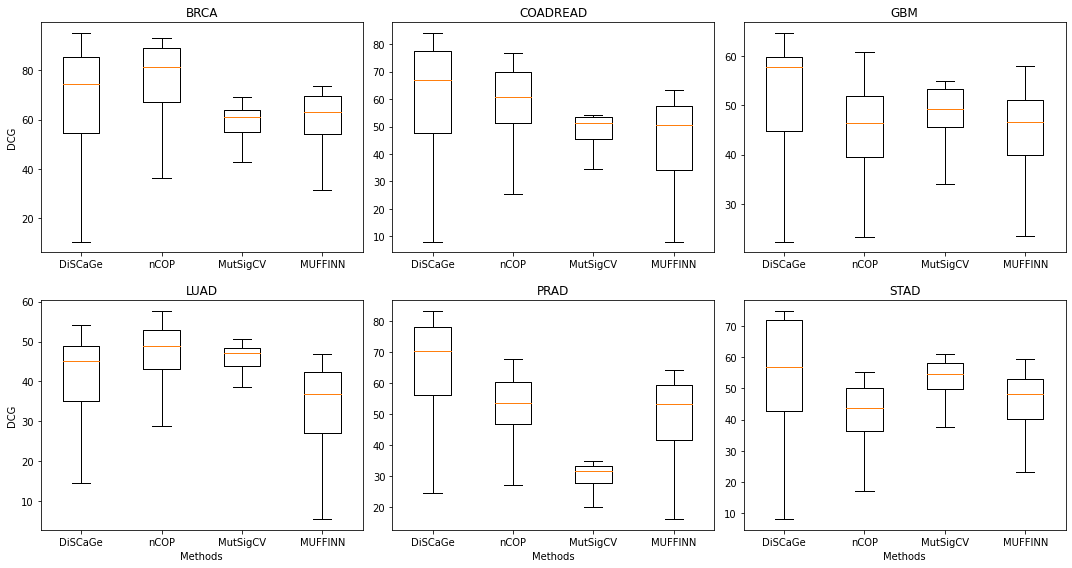

In [9]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
   
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list

    result_file_name = "./results_for_comparisons/related_methods/" + cancer_type + "_SNV_InDel_nCOP_out_results.txt"
    result_gene_list = get_gene_list_nCOP(result_file_name, N)
    all_results_cancer_type["nCOP"] = result_gene_list
    
    result_file_name = "./results_for_comparisons/related_methods/" + cancer_type + "_SNV_InDel_results.sig_genes.txt"
    result_gene_list = get_gene_list_mutsigcv(result_file_name, N)
    all_results_cancer_type["MutSigCV"] = result_gene_list
    
    result_file_name = "./results_for_comparisons/related_methods/DNmax_" + cancer_type + "_SNV_InDel.STRINGv10"
    result_gene_list = get_gene_list_muffinn(result_file_name, N)
    all_results_cancer_type["MUFFINN"] = result_gene_list
    
    all_results[cancer_type] = all_results_cancer_type
    

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)
output_file_name = "precision_related_methods.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N)
output_file_name =  "precision_related_methods_boxplot.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')


print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)
output_file_name = "dcg_related_methods.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

fig = generate_boxplot_dcg(all_results, N)
output_file_name =  "dcg_related_methods_boxplot.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Long-tail analysis
 - Prioritization of low-frequency mutated genes

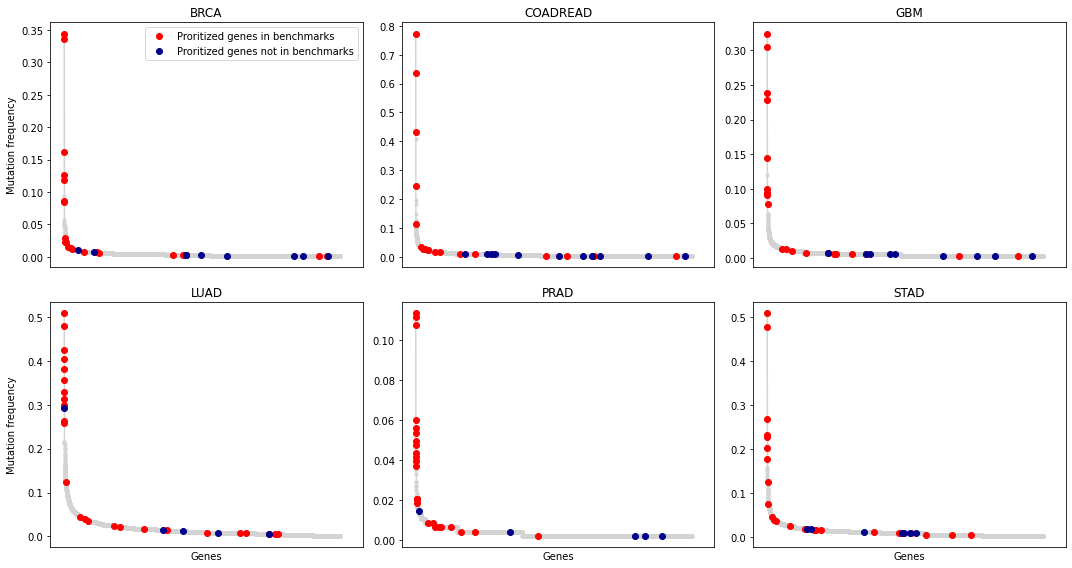

In [10]:
benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")
benchmark_genes = list(benchmark_df.index)

ids = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]


ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(5 * ncols, 4 * nrows))

plotRow=0
plotCol=0
for cancer_type in ids:
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    genes_anottate = get_gene_list(result_file_name, N)
    genes_anottate = genes_anottate[:30]

    maf_file_name = "../../../CancerData/" + cancer_type + "_SNV_InDel_preprocessed.maf"

    maf = read_maf(maf_file_name)
    bmm = pd.crosstab(maf.Tumor_Sample_Barcode, maf.Hugo_Symbol).clip(upper=1)
    
    genes = list(bmm)
    patients = list(bmm.index)
    patient_count = len(patients)
    long_tail = {}
    for gene in genes:
        gene_patient_count = sum(bmm[gene].tolist())
        long_tail[gene] = gene_patient_count / patient_count

    long_tail = sorted(long_tail.items(), key=lambda item: item[1], reverse = True)

    gene, frequency = zip(*long_tail) # unpack a list of pairs into two tuples
    
    note_gene = list(np.array(long_tail)[:,0])
    note_frequency = list(np.array(long_tail)[:,1])
    annotate_x_in = []
    annotate_y_in = []
    annotate_x_notin = []
    annotate_y_notin = []
    for g in genes_anottate:
        x = note_gene.index(g)
        y = float(note_frequency[x])

        if g in benchmark_genes:
            annotate_x_in.append(x)
            annotate_y_in.append(y)
        else:
            annotate_x_notin.append(x)
            annotate_y_notin.append(y)

    plt.sca(ax[plotRow,plotCol])
    #plt.plot(gene, frequency, '.-', color="darkblue")
    plt.plot(gene, frequency, '.-', color="lightgray")
    plt.plot(annotate_x_in, annotate_y_in, 'o', color="red", label="Proritized genes in benchmarks")
    plt.plot(annotate_x_notin, annotate_y_notin, 'o', color="darkblue", label="Proritized genes not in benchmarks")
        
    if plotRow == 0 and plotCol == 0:
        plt.legend()
    plt.title(cancer_type)

    xmin, xmax = plt.xlim()
    plt.xlim(xmin, xmax+xmax*0.03)
    plt.xticks([])
    #Add the Y Label
    if plotCol == 0:
        plt.ylabel("Mutation frequency")
    if plotRow == nrows - 1:
        plt.xlabel("Genes")
    
    #Walk in the subplots
    plotCol+=1
    if(plotCol==ncols):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)

    
#Select the first subplot. This is necessary for legend placemeallnt
plt.sca(ax[0,0])
fig.tight_layout(h_pad=1.5, w_pad=1)
fig.align_ylabels(ax[:, 0])

output_file_name =  "low_frequency_mutated_genes.png"
plt.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

plt.show() 

# Comparison with alternative version
- not using weighted mutation and asymmetric spreading strength
- value one for the weights of edges on GSSN

PRECISION:


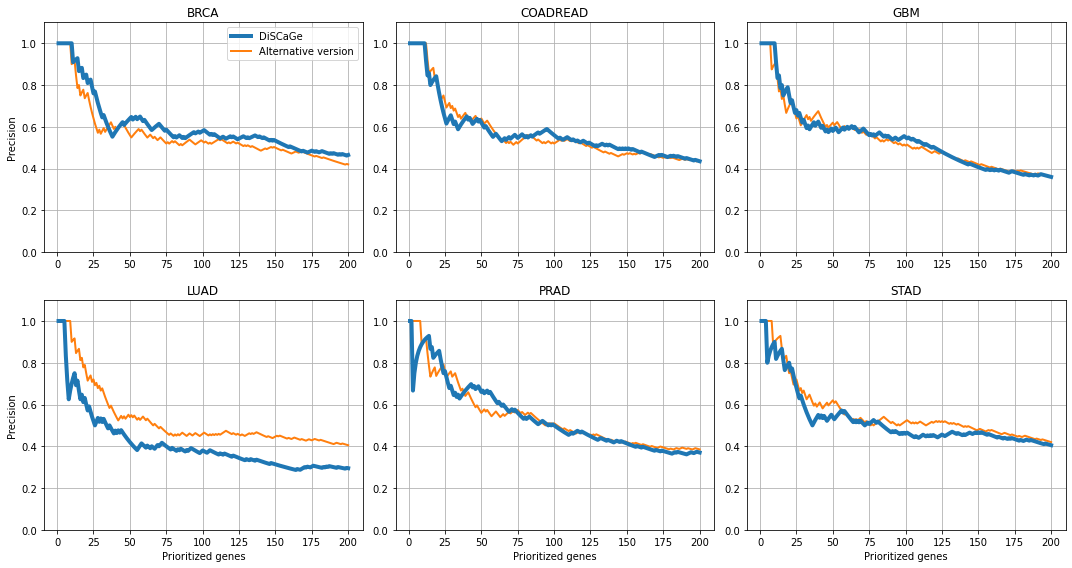


DCG:


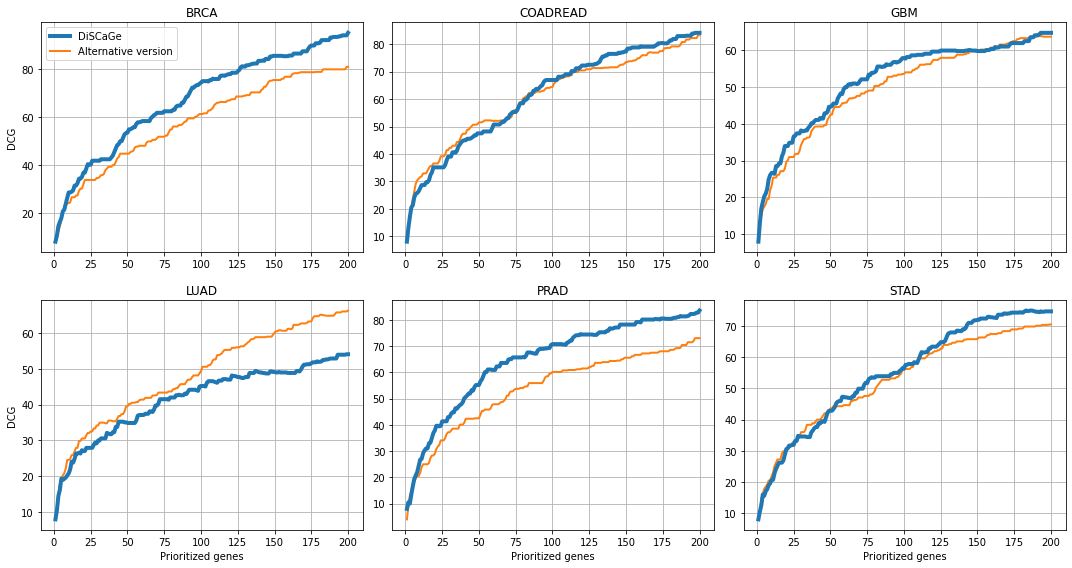

In [11]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list
    
    result_file_name = "./results_for_comparisons/alternative_version/" + cancer_type + "_SNV_InDel_preprocessed_no_wm_ass.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["Alternative version"] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)
output_file_name = "precision_wm_ass.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)
output_file_name = "dcg_wm_ass.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# HeatMap - Benchmarks

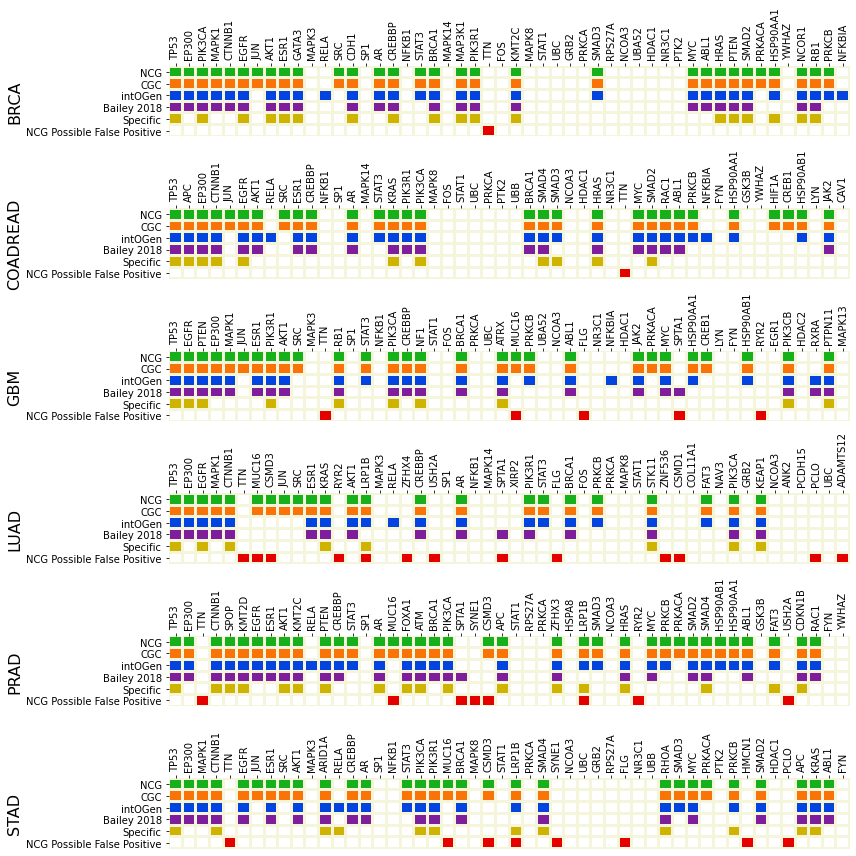

In [12]:
N = 50
cancer_type_list = ["BRCA", "GBM", "KIRC", "LUAD", "PRAD", "SKCM"]
cancer_type_list = ["BRCA", "GBM", "KIRC", "LUAD", "PRAD", "SKCM", "COADREAD", "STAD"]
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")

all_results_cancer_type = {}   
for cancer_type in cancer_type_list:      
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type[cancer_type] = result_gene_list

fig = generate_benchmarks_heatmap(all_results_cancer_type, N, benchmark_df)

output_file_name = "top50_benchmarks.png"
fig.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

# Automated literature-based analysis

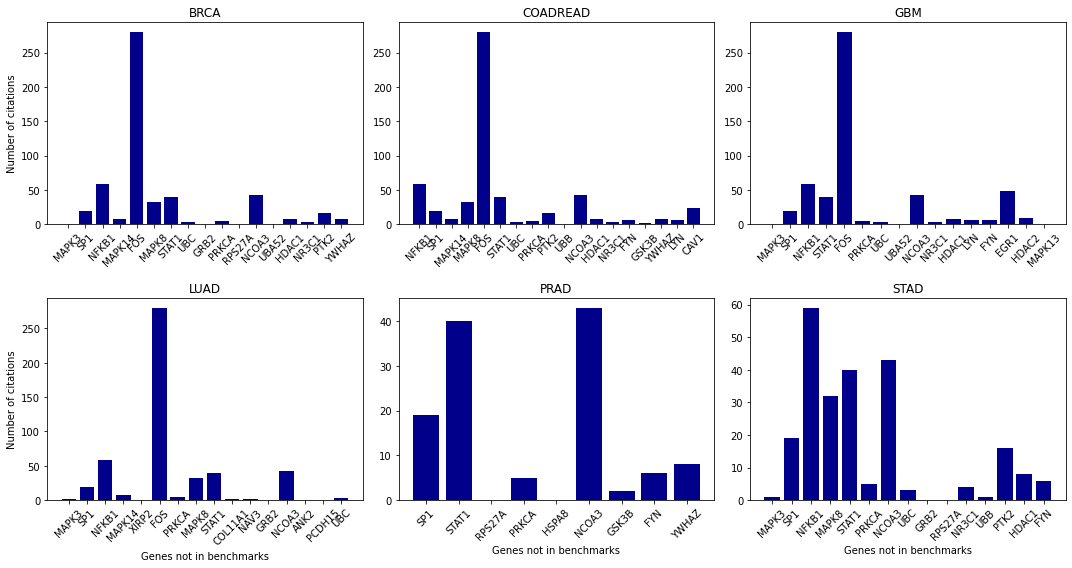

In [13]:
N = 50
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")

all_results_cancer_type = {}   
for cancer_type in cancer_type_list:   

    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
   
    genes_not_in_benchmark = []
    for gene in result_gene_list:
        if gene not in benchmark_df.index:
            genes_not_in_benchmark.append(gene)
    all_results_cancer_type[cancer_type] = genes_not_in_benchmark


cols = ["role", "cancer_normalized", "gene_normalized", "citation_count"]
cancermine_db = pd.read_csv("./results_for_comparisons/cancermine/cancermine_collated_2021-01-11.tsv", sep='\t', usecols=cols)


ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(5 * ncols, 4 * nrows))

plotRow=0
plotCol=0
for cancer_type in all_results_cancer_type:
    genes = all_results_cancer_type[cancer_type]
    citations_count = []
    for gene in genes:
        citations_count.append(cancermine_db[cancermine_db["gene_normalized"] == gene]["citation_count"].sum())

    plt.sca(ax[plotRow,plotCol])
    plt.title(cancer_type)
    plt.bar(genes, citations_count, color="darkblue")
    plt.xticks(rotation=45)
    
    if plotCol == 0:
        plt.ylabel("Number of citations")
    if plotRow == nrows - 1:
        plt.xlabel("Genes not in benchmarks")

    plotCol+=1
    if(plotCol==ncols):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)

plt.sca(ax[0,0])
fig.tight_layout(h_pad=1.5, w_pad=1)
fig.align_ylabels(ax[:, 0])    
    
output_file_name =  "citations_cancermine.png"
plt.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

plt.show() 

In [14]:
#generating list to test False positive discovery tool

import csv
import itertools

N = 50
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")

all_results_cancer_type = {}   
for cancer_type in cancer_type_list:   

    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
   
    genes_not_in_benchmark = []
    for gene in result_gene_list:
        if gene not in benchmark_df.index:
            genes_not_in_benchmark.append(gene)
    all_results_cancer_type[cancer_type] = genes_not_in_benchmark

output_file_name = "/home/cutigi/Documents/workspace/FalseDriverDiscovery_thesis/analysis/" + "DiSCaGe.results"

with open(output_file_name, "w") as outfile:
   writer = csv.writer(outfile,  delimiter="\t")
   writer.writerow(all_results_cancer_type.keys())
   writer.writerows(itertools.zip_longest(*all_results_cancer_type.values()))
outfile.close()

# Genes occurrences in driver and false positives benchmarks + CancerMine
 - Shows the potential on finding possible novel cancer genes

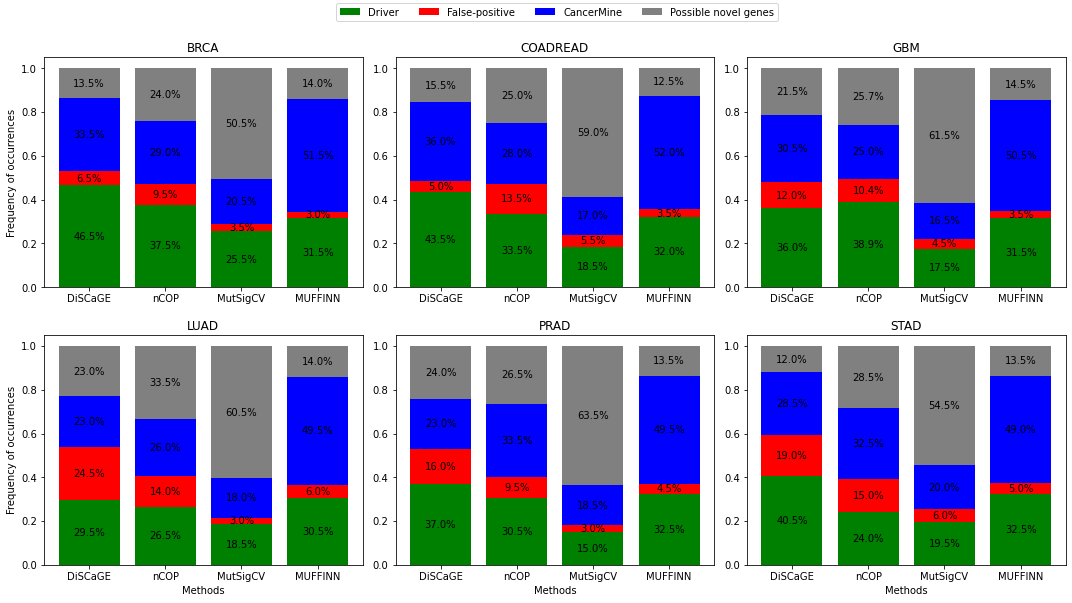

In [17]:
N = 200
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")

driver_benchmark = set(benchmark_df[benchmark_df["ncg"] > 0].index) | set(benchmark_df[benchmark_df["cgc"] > 0].index) | set(benchmark_df[benchmark_df["intogen"] > 0].index) | set(benchmark_df[benchmark_df["bailey"] > 0].index)
false_positive_benchmark = set(benchmark_df[benchmark_df["ncg_possible_false_positive"] > 0].index)
driver_benchmark = driver_benchmark - false_positive_benchmark

cols = ["role", "cancer_normalized", "gene_normalized", "citation_count"]
cancermine_db = pd.read_csv("./results_for_comparisons/cancermine/cancermine_collated_2021-01-11.tsv", sep='\t', usecols=cols)
genes_cancermine = set(cancermine_db["gene_normalized"])


result_file_name_list = ["../input/CANCERTYPE/output/CANCERTYPE_SNV_InDel_preprocessed.score.mutatedGenes",
                         "./results_for_comparisons/related_methods/CANCERTYPE_SNV_InDel_nCOP_out_results.txt",
                         "./results_for_comparisons/related_methods/CANCERTYPE_SNV_InDel_results.sig_genes.txt",
                         "./results_for_comparisons/related_methods/DNmax_CANCERTYPE_SNV_InDel.STRINGv10"]

all_results_cancer_type = {}   
for cancer_type in cancer_type_list:
    driver = []
    false = []
    cancermine = []
    not_in_other_sets = []
    all_genes = []
    for result_file_name_iter in result_file_name_list:

        result_file_name = result_file_name_iter.replace("CANCERTYPE", cancer_type)
        if "nCOP" in result_file_name:
            result_gene_list = get_gene_list_nCOP(result_file_name, N)
        elif "sig_genes" in result_file_name:
            result_gene_list = get_gene_list_mutsigcv(result_file_name, N)
        elif "DNmax" in result_file_name:
            result_gene_list = get_gene_list_muffinn(result_file_name, N)
        else:
            result_gene_list = get_gene_list(result_file_name, N)
            
        driver.append(set(result_gene_list) & set(driver_benchmark))
        false.append(set(result_gene_list) & set(false_positive_benchmark))
        all_genes.append(result_gene_list)
        
        driver_false = set(driver_benchmark) | set(false_positive_benchmark)
    
        other_genes = set(result_gene_list).difference(driver_false)
        
        cancermine_list = []
        not_in_other_sets_list = []
        for gene in other_genes:
            if gene in genes_cancermine:
                cancermine_list.append(gene)
            else:
                not_in_other_sets_list.append(gene)
        cancermine.append(cancermine_list)
        not_in_other_sets.append(not_in_other_sets_list)

    data = [driver, false, cancermine, not_in_other_sets, all_genes]
    all_results_cancer_type[cancer_type] = data


ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(5 * ncols, 4 * nrows))

axis_methods = [0,1,2,3]
methods = ["DiSCaGE", "nCOP", "MutSigCV", "MUFFINN"]
series_labels = ["Driver", "False-positive", "CancerMine", "Possible novel genes"]


plotRow=0
plotCol=0
for cancer_type in all_results_cancer_type:
    plt.sca(ax[plotRow,plotCol])
    plt.title(cancer_type)
    
    all_genes_count = [len(x) for x in all_results_cancer_type[cancer_type][4]]
    #print(all_genes_count)
    
    drivers_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][0]:
        drivers_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    false_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][1]:
        false_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    cancermine_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][2]:
        cancermine_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    not_in_sets_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][3]:
        not_in_sets_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
       
    data = [drivers_count, false_count, cancermine_count, not_in_sets_count]
    
    ax1 = plt.bar(methods, drivers_count, color="green")
    ax2 = plt.bar(methods, false_count, bottom=drivers_count, color="red")
    ax3 = plt.bar(methods, cancermine_count, bottom=[i+j for i,j in zip(drivers_count, false_count)], color="blue")
    ax4 = plt.bar(methods, not_in_sets_count, bottom=[i+j+k for i,j,k in zip(drivers_count, false_count, cancermine_count)], color="gray")
    
    for r1, r2, r3, r4 in zip(ax1, ax2, ax3, ax4):
        h1 = r1.get_height()
        h2 = r2.get_height()
        h3 = r3.get_height()
        h4 = r4.get_height()

        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2, "{:.1f}%".format(h1*100), ha="center", va="center")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2, "{:.1f}%".format(h2*100), ha="center", va="center")
        plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2, "{:.1f}%".format(h3*100), ha="center", va="center")
        plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2, "{:.1f}%".format(h4*100), ha="center", va="center")



    if plotCol == 0:
        plt.ylabel("Frequency of occurrences")
    if plotRow == nrows - 1:
        plt.xlabel("Methods")
        

    plotCol+=1
    if(plotCol==ncols):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)
    plt.ylim(0.0, 1.05)


plt.sca(ax[0,0])
fig.legend(series_labels, loc='upper center', bbox_to_anchor=(0.516, 1.05),ncol=7)
fig.tight_layout(h_pad=1.5, w_pad=1)
fig.align_ylabels(ax[:, 0])    

output_file_name =  "freq_occurr_related_methods_benchmarks_cancermine.png"
plt.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show() 

In [198]:
all_results_cancer_type["GBM"][0] ## drivers dos 4 metodos
all_results_cancer_type["GBM"][0][0] ## drivers do DiSCaGe
all_results_cancer_type["GBM"][1][0] ## false do DiSCaGe
all_results_cancer_type["GBM"][4][0] ## todos os genes do DiSCaGe
all_results_cancer_type["GBM"][4][1] ## todos os genes do nCOP
len(all_results_cancer_type["GBM"][4][1]) ## todos os genes do nCOP

144

# Boxplot of frequencies of prioritized genes
 - Shows the potential of identifying genes with low mutation frequencies

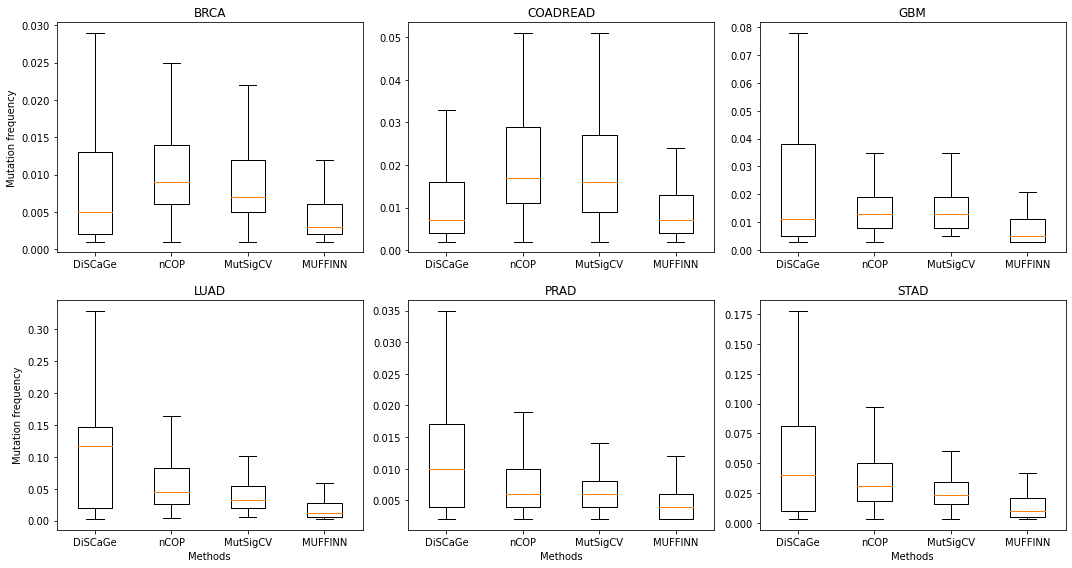

In [16]:
N = 200
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

all_results = {} 
all_results_cancer_type = {}   
for cancer_type in cancer_type_list:
    result_freq_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.gene.report"
    results_freq_df = pd.read_csv(result_freq_file_name, comment='#', sep='\t', usecols=["gene", "mutated_samples", "freq"])
    #results_freq_df = results_freq_df.sort_values(by=["mutated_samples"], ascending=False)
    #return list(results_df["gene"])[:N]  
    
    all_results_cancer_type = {}    
   
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    result_freq = list(results_freq_df[results_freq_df["gene"].isin(result_gene_list)]["freq"])
    all_results_cancer_type["DiSCaGe"] = result_freq
    
    result_file_name = "./results_for_comparisons/related_methods/" + cancer_type + "_SNV_InDel_nCOP_out_results.txt"
    result_gene_list = get_gene_list_nCOP(result_file_name, N)
    result_freq = list(results_freq_df[results_freq_df["gene"].isin(result_gene_list)]["freq"])
    all_results_cancer_type["nCOP"] = result_freq
    
    result_file_name = "./results_for_comparisons/related_methods/" + cancer_type + "_SNV_InDel_results.sig_genes.txt"
    result_gene_list = get_gene_list_mutsigcv(result_file_name, N)
    result_freq = list(results_freq_df[results_freq_df["gene"].isin(result_gene_list)]["freq"])
    all_results_cancer_type["MutSigCV"] = result_freq
    
    result_file_name = "./results_for_comparisons/related_methods/DNmax_" + cancer_type + "_SNV_InDel.STRINGv10"
    result_gene_list = get_gene_list_muffinn(result_file_name, N)
    result_freq = list(results_freq_df[results_freq_df["gene"].isin(result_gene_list)]["freq"])
    all_results_cancer_type["MUFFINN"] = result_freq
    
    all_results[cancer_type] = all_results_cancer_type


ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(5 * ncols, 4 * nrows))

plotRow=0
plotCol=0
for cancer_type in all_results:
    data = []
    methods = []
    all_results_cancer_type = all_results[cancer_type]
    for method in all_results_cancer_type:
        data.append(all_results_cancer_type[method])
        methods.append(method)
        #print(method, all_results_cancer_type[method])
    

    plt.sca(ax[plotRow,plotCol])
    plt.title(cancer_type)
    plt.boxplot(data, labels=methods, showfliers=False)
    
    if plotCol == 0:
        plt.ylabel("Mutation frequency")
    if plotRow == nrows - 1:
        plt.xlabel("Methods")

    plotCol+=1
    if(plotCol==ncols):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)

output_file_name =  "low_frequency_related_methods_boxplot.png"
plt.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')

plt.show() 

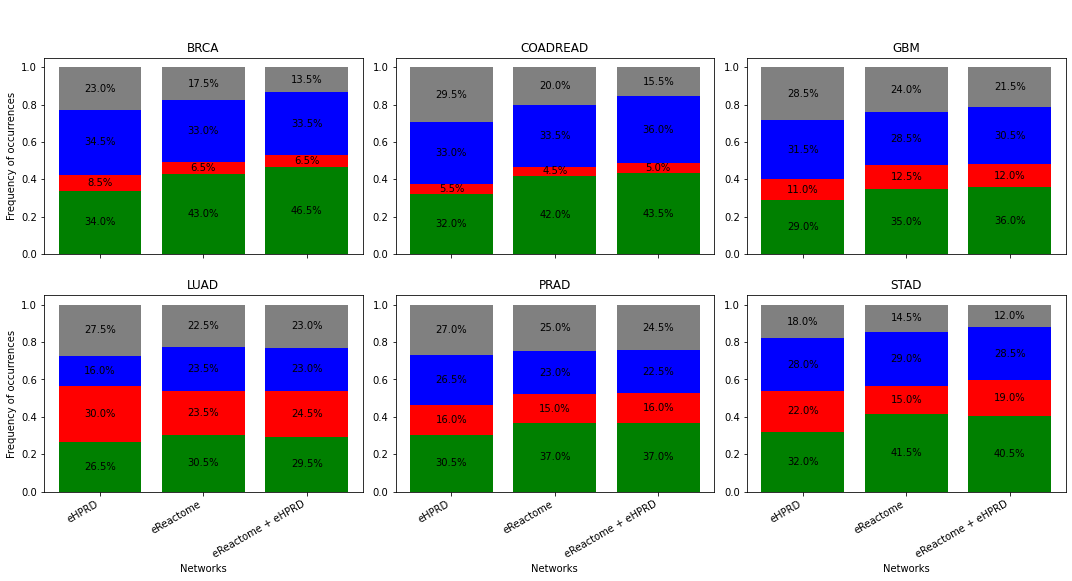

In [4]:
N = 200
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

benchmark_file_name = "./benchmarks/scores_benchmarks_genes.tsv"
benchmark_df = pd.read_csv(benchmark_file_name, sep='\t')
benchmark_df = benchmark_df.set_index("gene")

driver_benchmark = set(benchmark_df[benchmark_df["ncg"] > 0].index) | set(benchmark_df[benchmark_df["cgc"] > 0].index) | set(benchmark_df[benchmark_df["intogen"] > 0].index) | set(benchmark_df[benchmark_df["bailey"] > 0].index)
false_positive_benchmark = set(benchmark_df[benchmark_df["ncg_possible_false_positive"] > 0].index)
driver_benchmark = driver_benchmark - false_positive_benchmark

cols = ["role", "cancer_normalized", "gene_normalized", "citation_count"]
cancermine_db = pd.read_csv("./results_for_comparisons/cancermine/cancermine_collated_2021-01-11.tsv", sep='\t', usecols=cols)
genes_cancermine = set(cancermine_db["gene_normalized"])


all_results_cancer_type = {}   
for cancer_type in cancer_type_list:
    driver = []
    false = []
    cancermine = []
    not_in_other_sets = []
    all_genes = []
    networks_list = ["eHPRD", "eReactome", "eReactome_eHPRD"]

    for p in networks_list:
        result_file_name = "./results_for_comparisons/network_variation/" + cancer_type + "_SNV_InDel_preprocessed_" + p + "_.score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
            
        driver.append(set(result_gene_list) & set(driver_benchmark))
        false.append(set(result_gene_list) & set(false_positive_benchmark))
        all_genes.append(result_gene_list)
        
        driver_false = set(driver_benchmark) | set(false_positive_benchmark)
    
        other_genes = set(result_gene_list).difference(driver_false)
        
        cancermine_list = []
        not_in_other_sets_list = []
        for gene in other_genes:
            if gene in genes_cancermine:
                cancermine_list.append(gene)
            else:
                not_in_other_sets_list.append(gene)
        cancermine.append(cancermine_list)
        not_in_other_sets.append(not_in_other_sets_list)

    data = [driver, false, cancermine, not_in_other_sets, all_genes]
    all_results_cancer_type[cancer_type] = data


ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows,ncols,figsize=(5 * ncols, 4 * nrows))

axis_methods = [0,1,2,3]
methods = ["eHPRD", "eReactome", "eReactome + eHPRD"]
series_labels = ["Driver", "False-positive", "CancerMine", "Possible novel genes"]


plotRow=0
plotCol=0
for cancer_type in all_results_cancer_type:
    plt.sca(ax[plotRow,plotCol])
    plt.title(cancer_type)
    
    all_genes_count = [len(x) for x in all_results_cancer_type[cancer_type][4]]
    #print(all_genes_count)
    
    drivers_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][0]:
        drivers_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    false_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][1]:
        false_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    cancermine_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][2]:
        cancermine_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
        
    not_in_sets_count = []
    method_id = 0
    for x in all_results_cancer_type[cancer_type][3]:
        not_in_sets_count.append(len(x)/all_genes_count[method_id])
        method_id = method_id + 1
       
    data = [drivers_count, false_count, cancermine_count, not_in_sets_count]
    
    ax1 = plt.bar(methods, drivers_count, color="green")
    ax2 = plt.bar(methods, false_count, bottom=drivers_count, color="red")
    ax3 = plt.bar(methods, cancermine_count, bottom=[i+j for i,j in zip(drivers_count, false_count)], color="blue")
    ax4 = plt.bar(methods, not_in_sets_count, bottom=[i+j+k for i,j,k in zip(drivers_count, false_count, cancermine_count)], color="gray")
    
    for r1, r2, r3, r4 in zip(ax1, ax2, ax3, ax4):
        h1 = r1.get_height()
        h2 = r2.get_height()
        h3 = r3.get_height()
        h4 = r4.get_height()

        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2, "{:.1f}%".format(h1*100), ha="center", va="center")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2, "{:.1f}%".format(h2*100), ha="center", va="center")
        plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2, "{:.1f}%".format(h3*100), ha="center", va="center")
        plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2, "{:.1f}%".format(h4*100), ha="center", va="center")



    if plotCol == 0:
        plt.ylabel("Frequency of occurrences")
    if plotRow == nrows - 1:
        plt.xlabel("Networks")
        

    plotCol+=1
    if(plotCol==ncols):
        plotCol=0
        plotRow+=1   
    plt.tight_layout(h_pad=1.5, w_pad=1)
    plt.ylim(0.0, 1.05)


plt.sca(ax[0,0])
fig.legend(series_labels, loc='upper center', bbox_to_anchor=(0.516, 1.05),ncol=7)
fig.tight_layout(h_pad=1.5, w_pad=1)
fig.align_ylabels(ax[:, 0])
fig.autofmt_xdate()

output_file_name =  "freq_occurr_network_variation_benchmarks_cancermine.png"
plt.savefig("/home/cutigi/Dropbox/Doutorado/Tese/images/results/" + output_file_name, format='png', dpi=150, bbox_inches='tight')
plt.show()


# N = 200
# benchmark_driver_genes = get_benchmark_genes()
# cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]

# all_results = {} 
# for cancer_type in cancer_type_list:
#     all_results_cancer_type = {}    
    
#     networks_list = ["eReactome_eHPRD", "eReactome", "eHPRD"]
    
#     for p in networks_list:
#         result_file_name = "./results_for_comparisons/network_variation/" + cancer_type + "_SNV_InDel_preprocessed_" + p + "_.score.mutatedGenes"
#         result_gene_list = get_gene_list(result_file_name, N)
#         all_results_cancer_type[p] = result_gene_list
    

#     all_results[cancer_type] = all_results_cancer_type

# print("PRECISION:")    
# fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)

# fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N)


# print("\nDCG:")
# fig = generate_graphs_dcg(all_results, N)

# fig = generate_boxplot_dcg(all_results, N)


# fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)


# fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N)

# Não atualizado daqui pra baixo:

PRECISION:


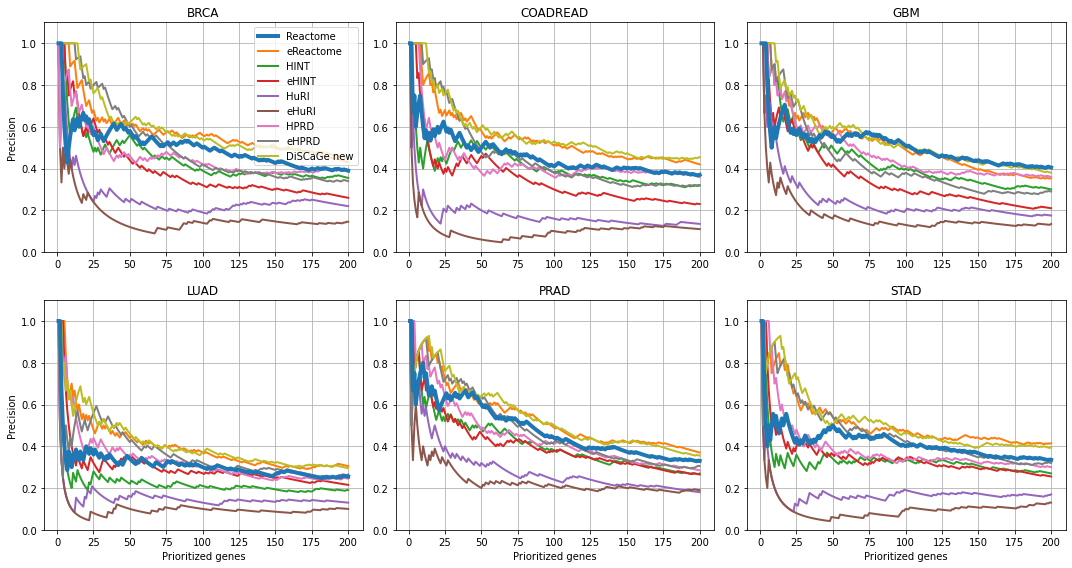

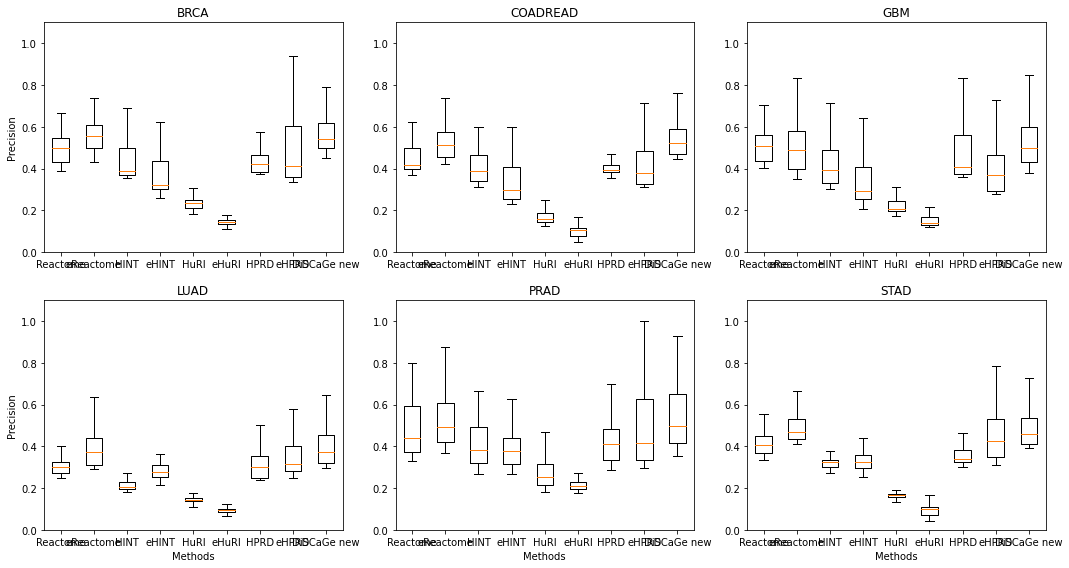


DCG:


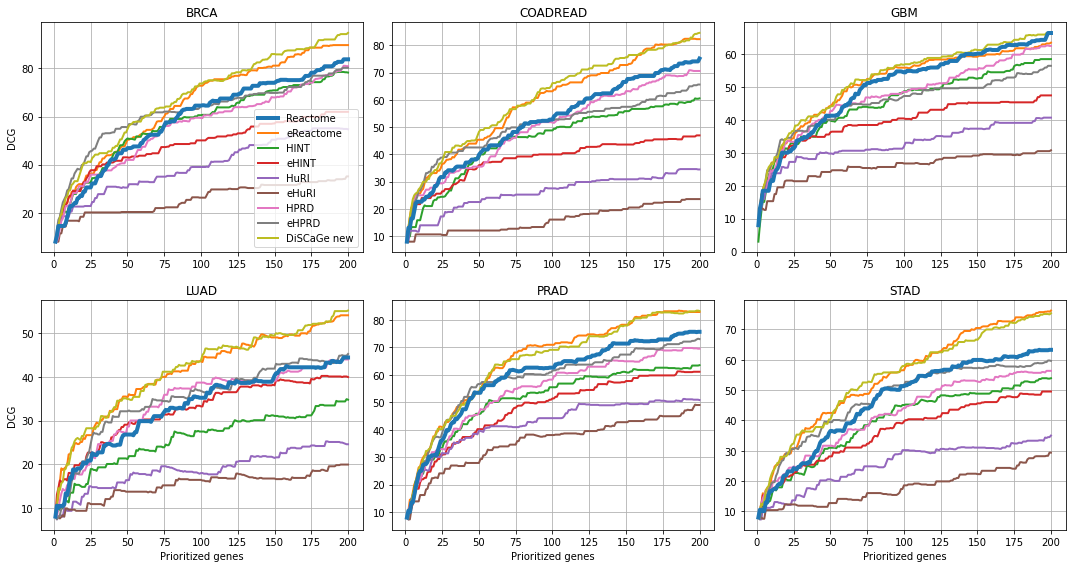

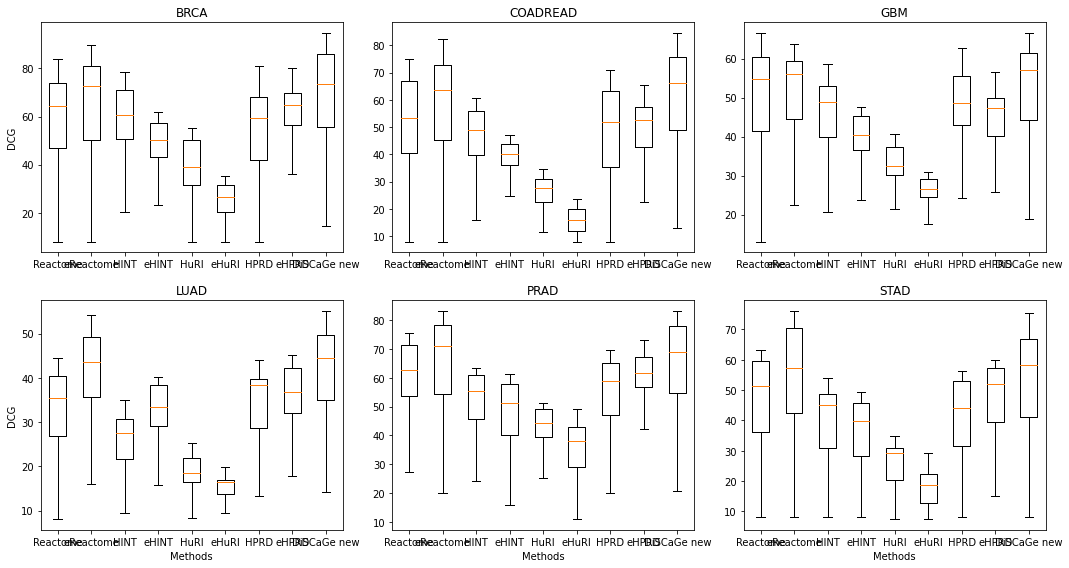

In [11]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]


all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
    
    networks_list = ["Reactome", "eReactome",
                     "HINT", "eHINT",
                     "HuRI", "eHuRI",
                     "HPRD", "eHPRD"]

    
    for p in networks_list:
        result_file_name = "./results_for_comparisons/networks_results/" + cancer_type + "_SNV_InDel_preprocessed" + p + "_.score.mutatedGenes"
        result_gene_list = get_gene_list(result_file_name, N)
        all_results_cancer_type[p] = result_gene_list
    
    result_file_name = "../input/" + cancer_type + "/output/new/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe new"] = result_gene_list
    

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)

fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N)


print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)

fig = generate_boxplot_dcg(all_results, N)


PRECISION:


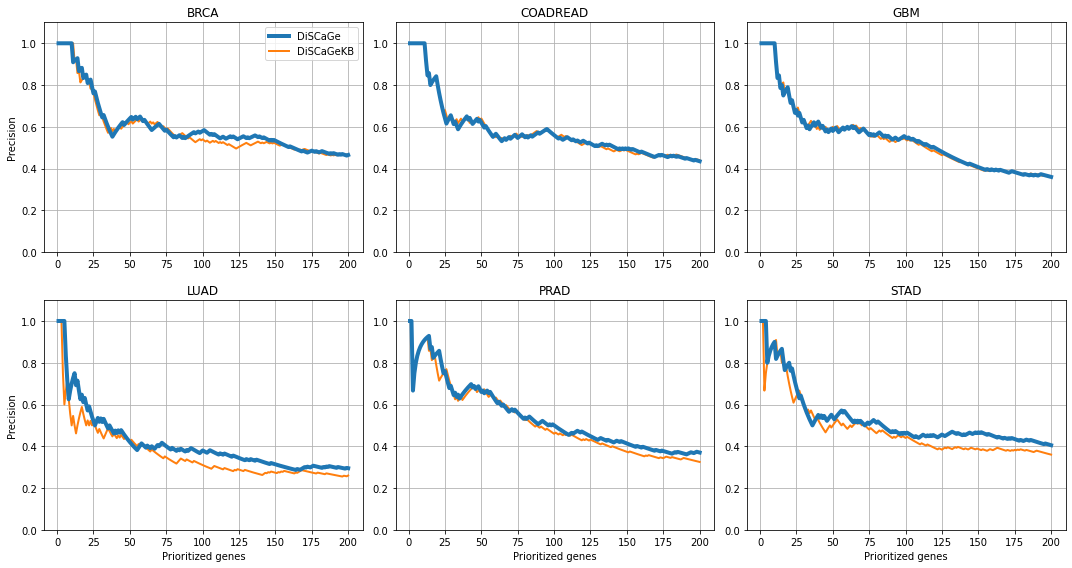

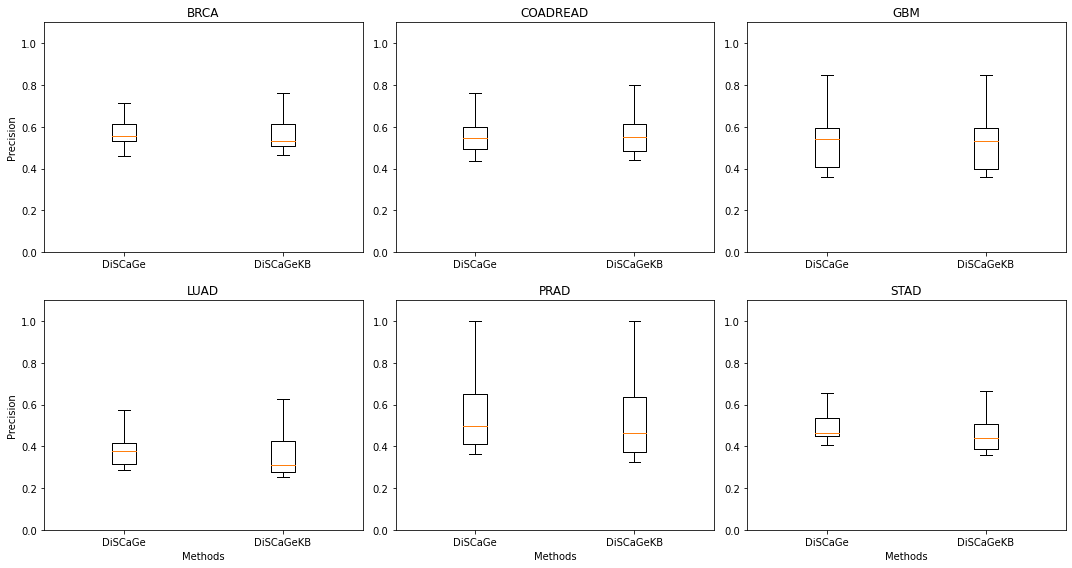


DCG:


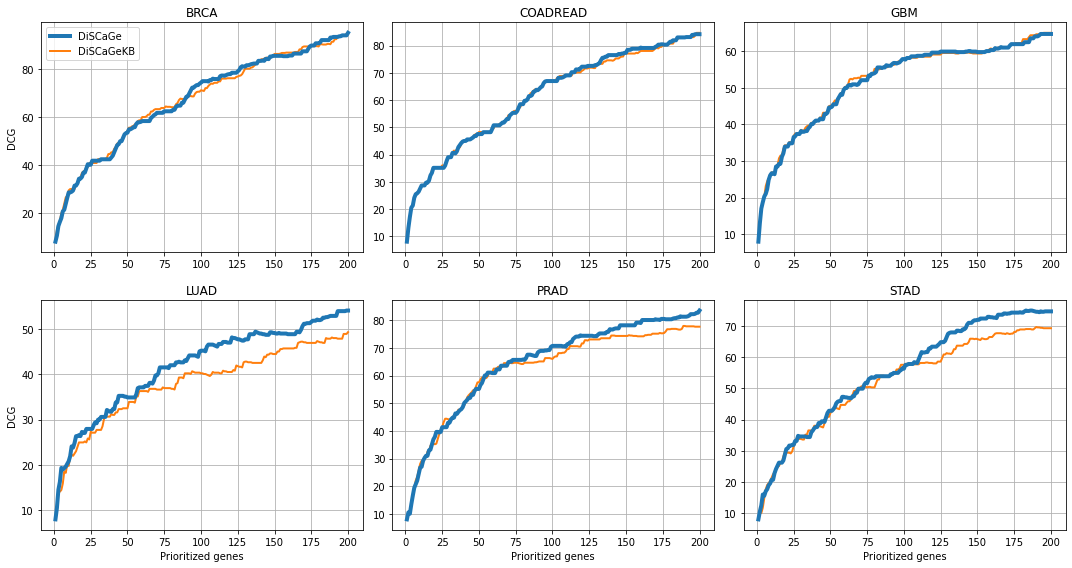

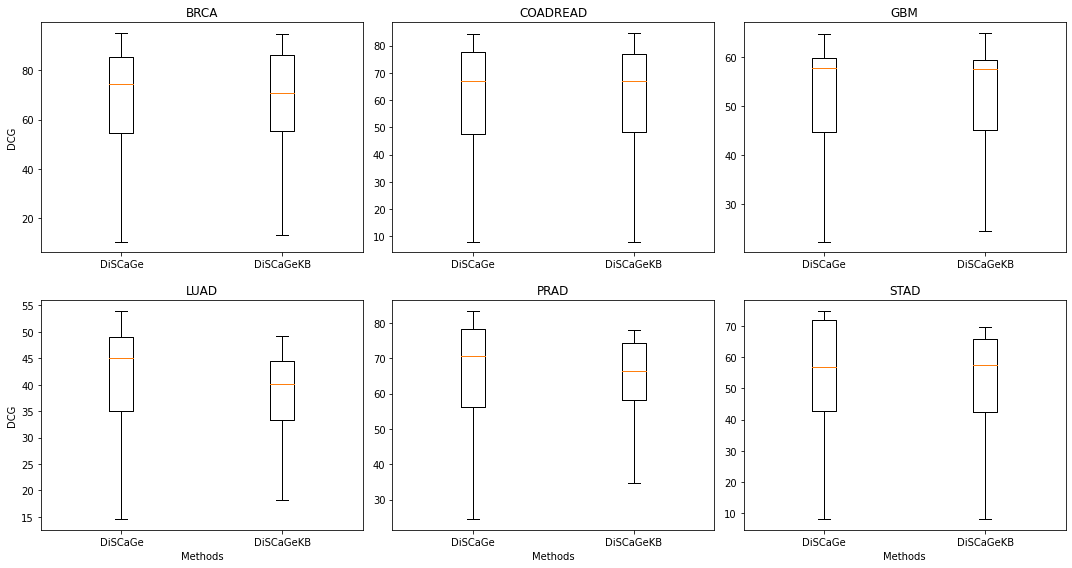

In [4]:
N = 200
benchmark_driver_genes = get_benchmark_genes()
cancer_type_list = ["BRCA", "COADREAD", "GBM", "LUAD", "PRAD", "STAD"]


all_results = {} 
for cancer_type in cancer_type_list:
    all_results_cancer_type = {}    
       
    result_file_name = "../input/" + cancer_type + "/output/" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGe"] = result_gene_list

    result_file_name = "../input/" + cancer_type + "/output_kb/KB_" + cancer_type + "_SNV_InDel_preprocessed.score.mutatedGenes"
    result_gene_list = get_gene_list(result_file_name, N)
    all_results_cancer_type["DiSCaGeKB"] = result_gene_list

    all_results[cancer_type] = all_results_cancer_type

print("PRECISION:")    
fig = generate_graphs_precision(all_results, benchmark_driver_genes, N)

fig = generate_boxplot_precision(all_results, benchmark_driver_genes, N)


print("\nDCG:")
fig = generate_graphs_dcg(all_results, N)

fig = generate_boxplot_dcg(all_results, N)
